In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("Medicalpremium.csv")

In [3]:
df = data.copy()

In [4]:
X = df.drop("PremiumPrice", axis=1)
y = df.PremiumPrice.copy()

In [5]:
num_cols = [i for i in X.columns if len(np.unique(X[i])) > 5]
num_cols

['Age', 'Height', 'Weight']

In [6]:
num_cols + ["BMI"]

['Age', 'Height', 'Weight', 'BMI']

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

In [8]:
class BMI(BaseEstimator, TransformerMixin):
    def __init__(self, bmi=True, bmiCat=True, dropbmi=False):
        self.bmi = bmi
        self.bmiCat = bmiCat
        self.dropbmi = dropbmi

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.bmi:
            X["BMI"] = X["Weight"]/(X["Height"]/100)**2
            
            if self.bmiCat:
                bins = [0, 18.5, 24.9, 29.9, 34.9, 100]
                labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Extreme']
                X["BMI_cat"] = pd.cut(X["BMI"], bins=bins, labels=labels, right=False)
                if self.dropbmi:
                    X = X.drop("BMI", axis=1)
                    return X
                else:
                    return X
            else:
                return X
        else:
            return X

In [9]:
class oneHot(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse=False, drop='first')

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        onehot_encoded = self.encoder.transform(X[self.columns])
        feature_names = self.encoder.get_feature_names_out()
        result_df = pd.DataFrame(onehot_encoded, columns=feature_names)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [10]:
class StdScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        num_cols = [i for i in X.columns if len(np.unique(X[i])) > 5]
        self.columns = num_cols
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        scaled_data = self.scaler.transform(X[self.columns])
        result_df = pd.DataFrame(scaled_data, columns=self.columns)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [11]:
pipe = Pipeline([
    ('bmi', BMI(bmi=False)),
    #('oneHot', oneHot(columns=["BMI_cat"])),
    ('scaler', StdScaler())
])

In [12]:
X_scaled = pd.DataFrame(pipe.fit_transform(X.copy()))

In [13]:
X_scaled

,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,Age,Height,Weight
0,0,0,0,0,0,0,0,0.233197,-1.306105,-1.399250
1,1,0,0,0,0,0,0,1.307981,1.170852,-0.277062
2,1,1,0,0,0,0,1,-0.411674,-1.008870,-1.258976
3,1,1,0,1,0,0,2,0.734763,1.468086,1.125674
4,0,0,0,1,0,0,1,-0.268369,-0.216244,0.774990
...,...,...,...,...,...,...,...,...,...,...
981,0,0,0,0,0,0,0,-1.701415,0.080991,-0.697882
982,1,1,0,0,0,0,3,1.594590,-1.504261,-0.487472
983,0,1,0,0,0,0,1,1.021372,-1.306105,-0.417335
984,1,1,0,0,1,0,1,0.376502,-1.008870,-0.277062


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [76]:
forest_reg = RandomForestRegressor()

In [77]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [78]:
pred = forest_reg.predict(X_test)

In [79]:
np.sqrt(mean_squared_error(y_test, pred))

2235.2021805373197

In [80]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

[]

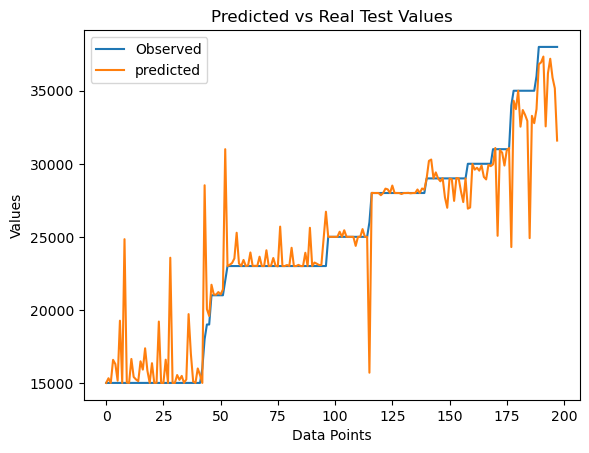

In [81]:
sns.lineplot(temp.Observed, label="Observed")
sns.lineplot(temp.predicted, label="predicted")
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Predicted vs Real Test Values')
plt.plot()

In [83]:
pred = forest_reg.predict(X_train)
np.sqrt(mean_squared_error(y_train, pred))

1138.197825222005

## cross validation forest

In [21]:
scores = cross_val_score(forest_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=5)

In [22]:
forest_rmse_scores = np.sqrt(-scores)

In [23]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [24]:
display_scores(forest_rmse_scores)

Scores: [3247.01644942 3268.20645274 3587.60145184 2511.40836475 2550.22466851]
Mean: 3032.891477449563
Standard deviation: 427.5132003074193


## hyperparameter forest

In [27]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [28]:
from sklearn.model_selection import RandomizedSearchCV

In [29]:
n_estimators = [int(i) for i in np.linspace(200, 2000, 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(i) for i in np.linspace(10, 110, 11)]
max_depth.append(None)
min_sample_split = [2, 5, 10]
min_sample_leaf = [1, 2, 4]
bootstrap = [True, False]

In [30]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_sample_split,
               'min_samples_leaf': min_sample_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['log2', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [31]:
forest_reg = RandomForestRegressor()

In [32]:
forest_rgrid = RandomizedSearchCV(estimator=forest_reg,
                                  param_distributions=random_grid,
                                  cv=3,
                                  verbose=2,
                                  random_state=42,
                                  n_jobs=-1,
                                  scoring='neg_mean_squared_error',
                                  return_train_score=True,
                                  n_iter=100)

score = forest_rgrid.fit(X_train, y_train)

#### saving

In [33]:
import joblib

joblib.dump(score, "forest1.pkl")

In [34]:
score = joblib.load("forest1.pkl")

In [56]:
cvres = score.cv_results_

In [57]:
temp = pd.DataFrame(cvres['params'])
temp["rmse"] = np.sqrt(-cvres["mean_test_score"])
temp.sort_values("rmse").head(20)

,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap,rmse
7,600,5,1,sqrt,60.0,False,3145.051387
24,1400,5,1,sqrt,80.0,False,3148.069194
21,1600,5,1,sqrt,70.0,False,3150.499203
32,800,5,1,sqrt,100.0,False,3155.334227
11,800,5,1,sqrt,90.0,False,3157.626644
20,1800,10,1,sqrt,30.0,False,3161.234199
73,400,5,1,log2,90.0,False,3163.198137
85,600,10,1,sqrt,40.0,False,3164.400386
68,1000,10,1,sqrt,80.0,False,3166.888603
16,600,5,2,log2,70.0,False,3168.495348


In [66]:
best_forest_rgrid = score.best_estimator_

In [69]:
pred = best_forest_rgrid.predict(X_test)

In [71]:
np.sqrt(mean_squared_error(y_test, pred))

2455.9795604375017

[]

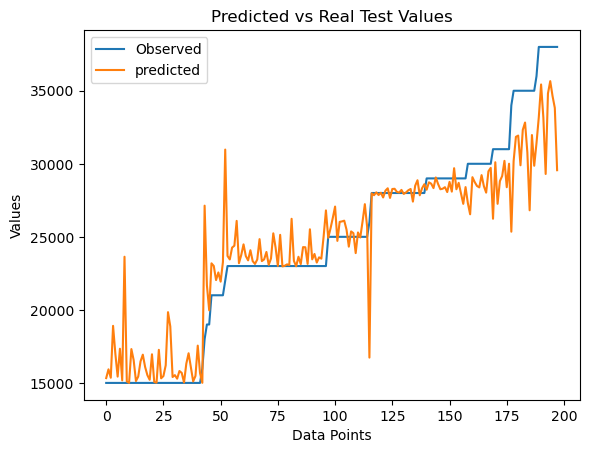

In [73]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

sns.lineplot(temp.Observed, label="Observed")
sns.lineplot(temp.predicted, label="predicted")
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Predicted vs Real Test Values')
plt.plot()

In [75]:
pred = best_forest_rgrid.predict(X_train)
np.sqrt(mean_squared_error(y_train, pred))

1124.3321013474156